## Introduction
The Basic Notebook that we based on was TenserFlow notebook for sentiment anaylsis, the notbook was under Apache License 2.0, here's the code and links for that notebook:

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>


## Setup - installations


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"
#You will use the AdamW optimizer from [tensorflow/models]
!pip install "tf-models-official==2.13.*"
!pip install dtaidistance


## Libraries imports

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text       # Import TF Text to handle the tokenization
import random
import json
import gc
import torch
import matplotlib.pyplot as plt

from official.nlp import optimization  # to create AdamW optimizer
from scipy.spatial.distance import cdist
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from scipy.spatial.distance import euclidean
from google.colab import drive
from scipy.special import expit as sigmoid
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from pathlib import Path
from dtaidistance import dtw
from tensorflow.keras.models import load_model

drive.mount('/content/drive')

tf.get_logger().setLevel('ERROR')

Mounted at /content/drive


## Set up GPU for training

---
Google Colab offers free GPUs and TPUs. Since we'll be training a large neural network it's best to utilize these features.

A GPU can be added by going to the menu and selecting:

Runtime -> Change runtime type -> Hardware accelerator: GPU

Then we need to run the following cell to specify the GPU as the device.

##Extra:

---


### How to run google colab notebook on a local machin gpu

Download docker image for google collab and the run the following command at your command line:

`docker run -it --gpus=all -p 127.0.0.1:9000:8080 -v C:\BERT:/workspace/BERT us-docker.pkg.dev/colab-images/public/runtime bash`

### Notice that you must need this lines at your notebook to actually run on gpu:

```
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
```


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA A100-SXM4-40GB


## Model Section - Choosing and building the model


In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_cased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3


## Our Model Classifier

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
    net = encoder(encoder_inputs)['pooled_output']
    net = tf.keras.layers.Dropout(0.25)(net)
    net = tf.keras.layers.Dense(512, activation='relu')(net)
    net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.Dropout(0.25)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)


In [ ]:
classifier_model = build_classifier_model()


Let's take a look at the model's structure.

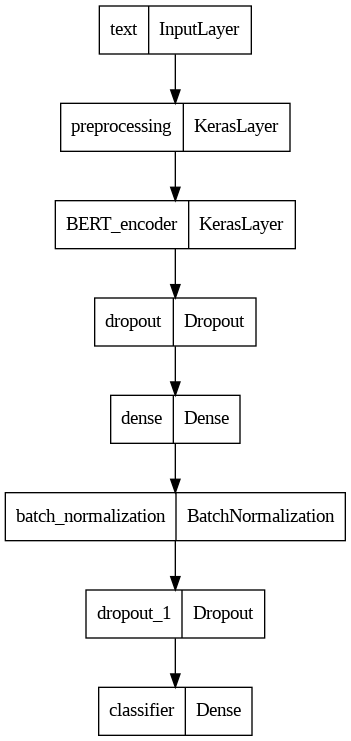

In [ ]:
tf.keras.utils.plot_model(classifier_model)

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

In [ ]:
def print_history_plot(history):
  history_dict = history.history

  acc = history_dict['binary_accuracy']
  val_acc = history_dict['val_binary_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)
  fig = plt.figure(figsize=(10, 6))
  fig.tight_layout()

  plt.subplot(2, 1, 1)
  # r is for "solid red line"
  plt.plot(epochs, loss, 'r', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Code section for functions that responsible for loading and processsing the texts, and making dataset from it

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 100
seed = 42
data_size_multiplier=8*2

 # Define a function to clean text
def clean_text(text):
        if not tf.is_tensor(text):
            text = tf.constant(text, dtype=tf.string)
        # Normalize text by converting to lowercase
        text = tf.strings.lower(text)
        # Remove '\n', '\r', and '\t'
        text = tf.strings.regex_replace(text, r"[\n\r\t]", " ")
        # Remove excessive whitespace
        text = tf.strings.regex_replace(text, r"\s+", " ")
        # Optionally, remove numbers if they're deemed irrelevant. Uncomment if needed.
        text = tf.strings.regex_replace(text, r"\d+", " ")
        # Remove special characters except apostrophes and periods (which might be relevant for sentence boundary detection)
        text = tf.strings.regex_replace(text, r"[^a-z0-9'. ]", " ")
        # Trim leading and trailing whitespace
        text = tf.strings.strip(text)
        return text.numpy().decode('utf-8')  # Convert from tensor to string

def load_texts_from_directory(directory_path, aggregate_by_subfolder=True):
    """
    Load texts from files in the given directory, optionally aggregating them by subfolder or by filenames if no subfolders exist.

    Parameters:
    - directory_path (str): Path to the directory containing text files or subdirectories with text files.
    - aggregate_by_subfolder (bool): If True, returns a dictionary where each key is a subfolder name (author),
      and its value is a list of text contents from that author. If no subfolders are present, or if False,
      returns a dictionary with filenames as keys and text contents as values.

    Returns:
    - texts_dictionary (dict): Depending on `aggregate_by_subfolder` and the presence of subfolders, returns a dictionary
      with either subfolder names or filenames as keys and lists of text contents as values.
    """
    texts_dictionary = {}
    subfolders_exist = any(os.path.isdir(os.path.join(directory_path, i)) for i in os.listdir(directory_path))

    # Determine whether to aggregate by subfolder or directly by filenames
    aggregate_by = aggregate_by_subfolder and subfolders_exist

    for root, dirs, files in os.walk(directory_path):
        # Break the loop if not aggregating by subfolders and the first directory walk is done
        if not aggregate_by and root != directory_path:
            break
        for name in files:
            filepath = os.path.join(root, name)
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    text = f.read()
            except UnicodeDecodeError:
                with open(filepath, 'r', encoding='iso-8859-1') as f:
                    text = f.read()
            key = os.path.basename(root) if aggregate_by else name
            if key not in texts_dictionary:
                texts_dictionary[key] = []
            texts_dictionary[key].append(text)
    return texts_dictionary


def preprocess_data_for_authors(authors_texts_dictionary, author_a, author_b, chunk_size=400, test_size=0.2, validation_split=0.5):
    """
    Prepares data from two authors for training by cleaning, chunking, and converting to TensorFlow datasets.
    This function expects a dictionary with authors' names as keys and lists of their texts as values.

    Parameters:
    - authors_texts_dictionary: Dictionary with authors' names as keys and lists of their texts as values.
    - author_a (str): Name of author A.
    - author_b (str): Name of author B.
    - chunk_size, test_size, validation_split: See previous description.

    Returns:
    - train_ds, val_ds, test_ds (tf.data.Dataset): Training, validation, and test datasets ready for fine-tuning.
    """

    def clean_and_chunk_texts(texts_list, chunk_size=400):
        cleaned_texts = []
        for text in texts_list:
            # Apply the clean_text function here on each text
            cleaned_text = clean_text(text)
            words = cleaned_text.split()  # Split into words
            # Chunk the cleaned text
            for i in range(0, len(words), chunk_size):
                chunk = ' '.join(words[i:i+chunk_size])
                cleaned_texts.append(chunk)
        return cleaned_texts

    # Get texts for both authors and clean & chunk them
    texts_a = clean_and_chunk_texts(authors_texts_dictionary[author_a], chunk_size=chunk_size)
    texts_b = clean_and_chunk_texts(authors_texts_dictionary[author_b], chunk_size=chunk_size)

    # Labels
    labels_a = [0] * len(texts_a)
    labels_b = [1] * len(texts_b)

    # Combine texts and labels
    all_texts = texts_a + texts_b
    all_labels = labels_a + labels_b

    # Multiply the data
    all_texts *= data_size_multiplier
    all_labels *= data_size_multiplier

    # Split the data
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(all_texts, all_labels, test_size=test_size, random_state=seed)
    val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=validation_split, random_state=seed)

    # Convert to TensorFlow Datasets
    # The training dataset is shuffled to optimised training process
    train_ds = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
    train_ds = train_ds.shuffle(buffer_size=len(train_texts), reshuffle_each_iteration=True)
    train_ds = train_ds.batch(batch_size).prefetch(AUTOTUNE)

    val_ds = tf.data.Dataset.from_tensor_slices((val_texts, val_labels)).batch(batch_size).prefetch(AUTOTUNE)
    test_ds = tf.data.Dataset.from_tensor_slices((test_texts, test_labels)).batch(batch_size).prefetch(AUTOTUNE)

    return train_ds, val_ds, test_ds

def evaluate_and_calculate_distance_matrix_shakespeare(classifier_model, shakespeare_texts, batch_factor, shakespeare_filenames, output_dir, iteration):
    """
    Processes Shakespeare's texts with a classifier model to generate and save a distance matrix based on the model's predictions.

    Parameters:
    - classifier_model: The trained classification model.
    - shakespeare_texts: A list of preprocessed Shakespeare texts.
    - batch_factor: The size for aggregating predictions into chunks.
    - shakespeare_filenames: A list of filenames corresponding to the Shakespeare texts.
    - output_dir: Directory where to save the processed data and distance matrix.
    - iteration: Current iteration number, used for naming saved files.
    """

    # Generate predictions for each Shakespeare text
    predictions_dict = {}
    for i, text in enumerate(shakespeare_texts):
        predictions = classifier_model.predict(np.array([text]))[:, 0]
        predictions_dict[shakespeare_filenames[i]] = predictions

    # Aggregate predictions into chunks for each text
    aggregated_predictions_dict = {}
    for filename, predictions in predictions_dict.items():
        # Split predictions into chunks and calculate mean for each chunk, equal to old line of code: list0 = [sum(g) / batch_factor for g in zip(*[iter(data)] * batch_factor)]
        num_chunks = max(1, len(predictions) // batch_factor)
        chunks = np.array_split(predictions, num_chunks)
        # chunks = np.array_split(predictions, len(predictions) // batch_factor)
        aggregated_chunks = [np.mean(chunk) for chunk in chunks]
        aggregated_predictions_dict[filename] = np.array(aggregated_chunks)

    # Calculate the DTW distance matrix among aggregated predictions
    filenames = list(aggregated_predictions_dict.keys())
    dist_matrix = np.zeros((len(filenames), len(filenames)))
    for i, filename1 in enumerate(filenames):
        for j, filename2 in enumerate(filenames):
            if i != j:  # Skip self-comparison
                distance = dtw.distance(aggregated_predictions_dict[filename1], aggregated_predictions_dict[filename2])
                dist_matrix[i, j] = distance
    # Ensure the distance matrix is symmetric
    dist_matrix = (dist_matrix + dist_matrix.T) / 2

    # Save the aggregated predictions and distance matrix for analysis
    np.save(f"{output_dir}/Signal_{iteration}.npy", aggregated_predictions_dict)
    np.save(f"{output_dir}/dist_mat_{iteration}.npy", dist_matrix)

    return dist_matrix






## Functions for evaluation, distance matrix and isolation forest

In [ ]:
def generate_writer_pairs(writers, filepath):
    """Generates or loads writer pairs using actual writer names."""
    if os.path.exists(filepath):
        # Load existing pairs from the file
        with open(filepath, 'r') as file:
            writer_pairs = json.load(file)
    else:
        # Sort writers alphabetically
        sorted_writers = sorted(writers)
        # Generate all possible pairs from the given list of writers
        writer_pairs = [(sorted_writers[i], sorted_writers[j]) for i in range(len(sorted_writers)) for j in range(i + 1, len(sorted_writers))]
        # random.shuffle(writer_pairs)  # Shuffle the pairs to randomize the order
        with open(filepath, 'w') as file:
            json.dump(writer_pairs, file)  # Save the newly generated pairs
    return writer_pairs

def save_state(training_state, filepath):
    """Saves the current training state to a file."""
    with open(filepath, 'w') as f:
        json.dump(training_state, f)

def load_state(filepath):
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            return json.load(f)
    else:
        return {'current_pair_index': 0}  # Default starting state


def detect_outliers_with_isolation_forest(distance_matrix, outlier_threshold , num_trees, percentile_threshold , filenames):
    """
    Detects outliers in a distance matrix using Isolation Forest and prints the filenames of detected outliers.

    Parameters:
    - distance_matrix (np.array): The distance matrix representing dissimilarities between samples.
    - outlier_threshold (float): The threshold for deciding whether a sample is an outlier based on the Isolation Forest score.
    - num_trees (int): Number of trees to use in the Isolation Forest.
    - filenames (list): List of filenames corresponding to the samples in the distance matrix.
    - percentile_threshold (float): The percentile threshold used to identify outliers based on the distance sum.

    Returns:
    - anomaly_scores, detected_outliers
    """

    isolation_forest = IsolationForest(n_estimators=num_trees,warm_start=True, random_state=42)
    isolation_forest.fit(distance_matrix)
    anomaly_scores = isolation_forest.decision_function(distance_matrix)
    predictions = isolation_forest.predict(distance_matrix)

    outlier_indices = np.where(anomaly_scores < outlier_threshold)[0]
    print('\n++++++++++++++++++++++++++++++++++++')
    print("Outlier Detection Results:", '\n')
    if len(outlier_indices) > 0:
        for index in outlier_indices:
            if index < len(filenames):
                print(filenames[index], index)
    else:
        print("No outliers detected based on the Isolation Forest score.")
    print('\n++++++++++++++++++++++++++++++++++++')

    # Process based on distance sums
    distance_sums = np.sum(distance_matrix, axis=1)
    high_distance_indices = np.where(distance_sums > np.percentile(distance_sums, percentile_threshold))[0]
    detected_outliers = []
    print("Potential outliers based on distance sum:")
    for index in high_distance_indices:
        if index < len(filenames):
            print(filenames[index], index)
            detected_outliers.append((filenames[index], index))
    print('\n++++++++++++++++++++++++++++++++++++')
    return anomaly_scores, detected_outliers

############################ Iteration: 421 Processing pair: Lord of the Rings vs Mary Shelley ###############################################
Loading model from /content/drive/MyDrive/Lee_sh/LEE/Bert/continues_shakespeare_bert_model_16_4_24/saved_models/cp-iteration-421-imposter-Lord of the Rings-vs-Mary Shelley.ckpt
Loaded model and skipping training.
37/37 [==============================] - 248s 7s/step - loss: 0.2138 - binary_accuracy: 0.9432
################################################################
Binary Loss: 0.21380199491977692
Binary Accuracy: 0.9432373642921448
################################################################
1/1 [==============================] - 0s 196ms/step

++++++++++++++++++++++++++++++++++++
Outlier Detection Results: 

text to classify.txt 0
King Henry IV, Part 1.txt 1
CYMBELINE.txt 2
A LOVERS COMPLAINT.txt 3
A MIDSUMMER NIGHT_S DREAM.txt 4
A Yorkshire Tragedy by Shakespeare.txt 5
Arden of Feversham.txt 6
AS YOU LIKE IT.txt 7
KING EDWARD III by 

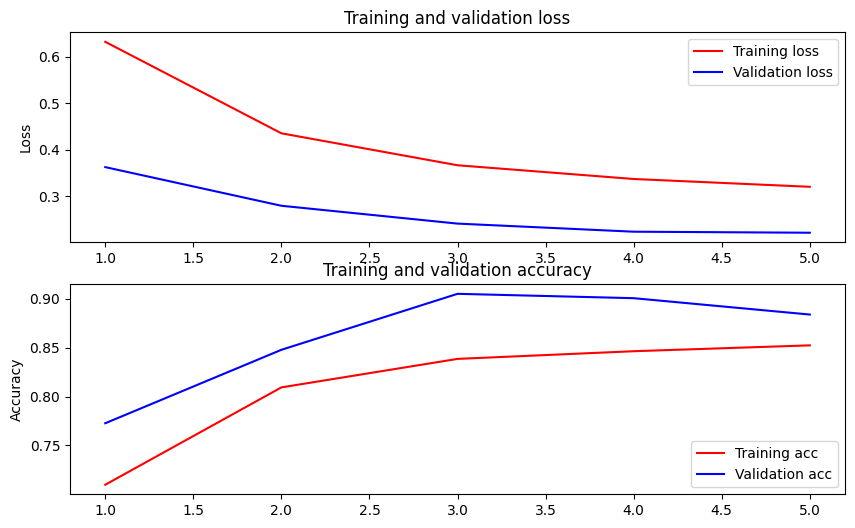

27/27 [==============================] - 182s 7s/step - loss: 0.2218 - binary_accuracy: 0.8891
################################################################
Binary Loss: 0.22180254757404327
Binary Accuracy: 0.8891369104385376
################################################################
1/1 [==============================] - 0s 192ms/step

++++++++++++++++++++++++++++++++++++
Outlier Detection Results: 

text to classify.txt 0
King Henry IV, Part 1.txt 1
CYMBELINE.txt 2
A LOVERS COMPLAINT.txt 3
A MIDSUMMER NIGHT_S DREAM.txt 4
A Yorkshire Tragedy by Shakespeare.txt 5
Arden of Feversham.txt 6
AS YOU LIKE IT.txt 7
KING EDWARD III by Shakespeare.txt 8
KING HENRY VI Part II.txt 9
Fair Em by Shakespeare.txt 10
KING HENRY VI part I.txt 11
KING HENRY V.txt 12
KING RICHARD III.txt 13
KING HENRY VI Part III.txt 14
KING RICHARD II.txt 15
KING HENRY VIII.txt 16
KING JOHN.txt 17
Merchant of Venice.txt 18
Love_s Labour_s Lost.txt 19
Locrine Mucedorus by Shakespeare.txt 20
MUCH ADO ABOUT NOTHIN

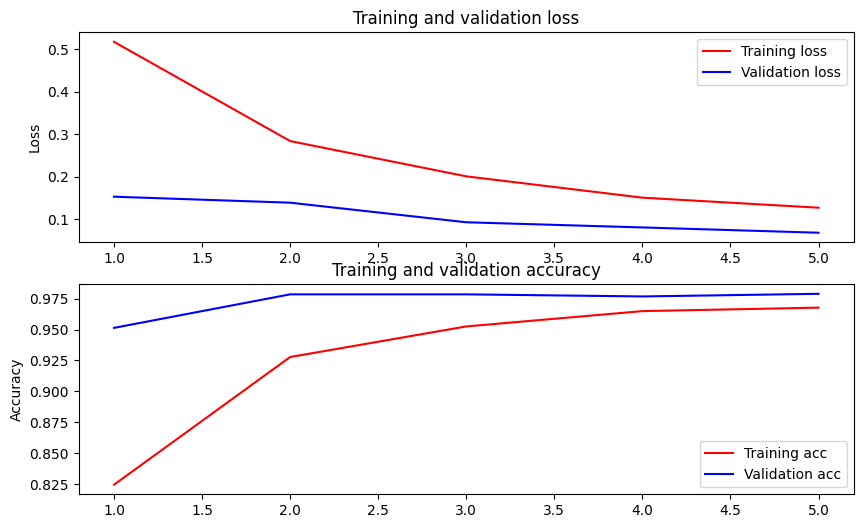

24/24 [==============================] - 160s 7s/step - loss: 0.0676 - binary_accuracy: 0.9814
################################################################
Binary Loss: 0.06761684268712997
Binary Accuracy: 0.9813874959945679
################################################################
1/1 [==============================] - 1s 696ms/step

++++++++++++++++++++++++++++++++++++
Outlier Detection Results: 

text to classify.txt 0
King Henry IV, Part 1.txt 1
CYMBELINE.txt 2
A LOVERS COMPLAINT.txt 3
A MIDSUMMER NIGHT_S DREAM.txt 4
A Yorkshire Tragedy by Shakespeare.txt 5
Arden of Feversham.txt 6
AS YOU LIKE IT.txt 7
KING EDWARD III by Shakespeare.txt 8
KING HENRY VI Part II.txt 9
Fair Em by Shakespeare.txt 10
KING HENRY VI part I.txt 11
KING HENRY V.txt 12
KING RICHARD III.txt 13
KING HENRY VI Part III.txt 14
KING RICHARD II.txt 15
KING HENRY VIII.txt 16
KING JOHN.txt 17
Merchant of Venice.txt 18
Love_s Labour_s Lost.txt 19
Locrine Mucedorus by Shakespeare.txt 20
MUCH ADO ABOUT NOTHIN

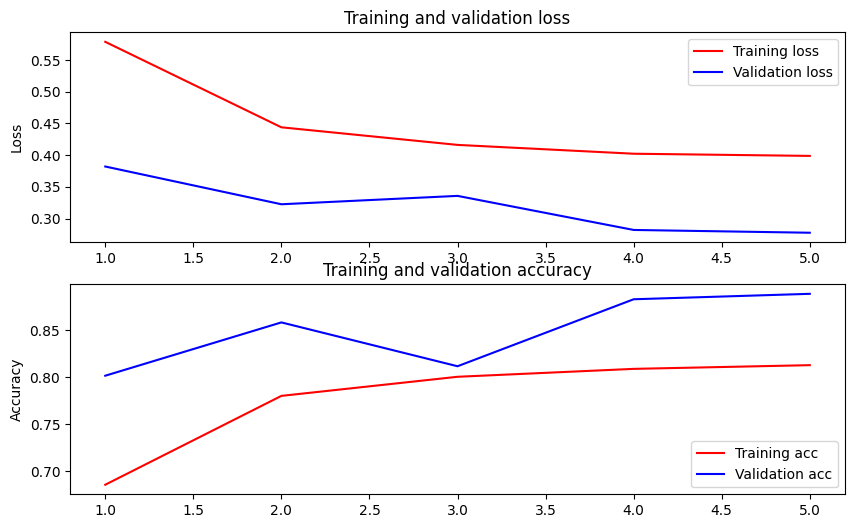

54/54 [==============================] - 366s 7s/step - loss: 0.2811 - binary_accuracy: 0.8882
################################################################
Binary Loss: 0.2811477780342102
Binary Accuracy: 0.8882057070732117
################################################################
1/1 [==============================] - 1s 789ms/step

++++++++++++++++++++++++++++++++++++
Outlier Detection Results: 

text to classify.txt 0
King Henry IV, Part 1.txt 1
CYMBELINE.txt 2
A LOVERS COMPLAINT.txt 3
A MIDSUMMER NIGHT_S DREAM.txt 4
A Yorkshire Tragedy by Shakespeare.txt 5
Arden of Feversham.txt 6
AS YOU LIKE IT.txt 7
KING EDWARD III by Shakespeare.txt 8
KING HENRY VI Part II.txt 9
Fair Em by Shakespeare.txt 10
KING HENRY VI part I.txt 11
KING HENRY V.txt 12
KING RICHARD III.txt 13
KING HENRY VI Part III.txt 14
KING RICHARD II.txt 15
KING HENRY VIII.txt 16
KING JOHN.txt 17
Merchant of Venice.txt 18
Love_s Labour_s Lost.txt 19
Locrine Mucedorus by Shakespeare.txt 20
MUCH ADO ABOUT NOTHING

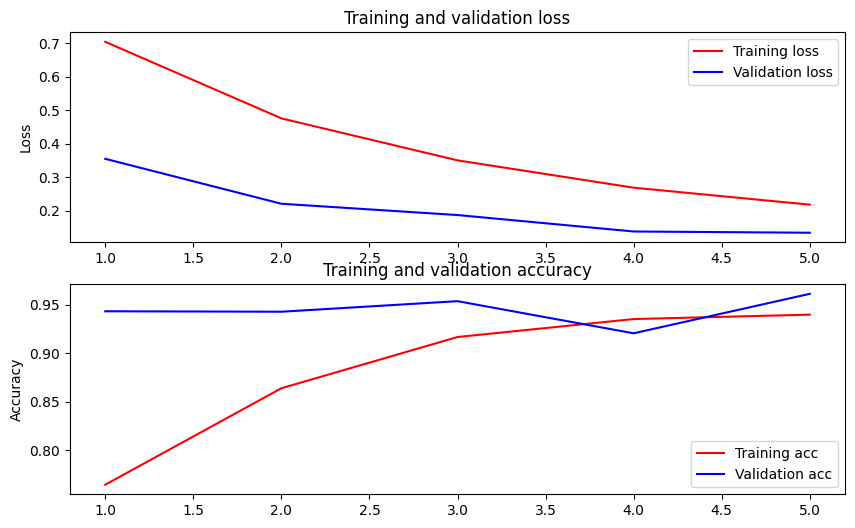

22/22 [==============================] - 142s 6s/step - loss: 0.1367 - binary_accuracy: 0.9546
################################################################
Average Loss after 5 pairs: 0.18421747535467148
Average Accuracy after 5 pairs: 0.9313197731971741
################################################################
################################################################
Binary Loss: 0.13671821355819702
Binary Accuracy: 0.9546313881874084
################################################################
1/1 [==============================] - 0s 189ms/step

++++++++++++++++++++++++++++++++++++
Outlier Detection Results: 

text to classify.txt 0
King Henry IV, Part 1.txt 1
CYMBELINE.txt 2
A LOVERS COMPLAINT.txt 3
A MIDSUMMER NIGHT_S DREAM.txt 4
A Yorkshire Tragedy by Shakespeare.txt 5
Arden of Feversham.txt 6
AS YOU LIKE IT.txt 7
KING EDWARD III by Shakespeare.txt 8
KING HENRY VI Part II.txt 9
Fair Em by Shakespeare.txt 10
KING HENRY VI part I.txt 11
KING HENRY V.txt 12
KIN

In [ ]:

# Training Parameters
epochs = 5
init_lr = 1e-4
batch_factor = 4
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True)
]

def main_workflow():

    # Paths
    imposters_dir = '/content/drive/MyDrive/Lee_sh/LEE/Bert/continues_shakespeare_bert_model_16_4_24/cleaned_imposters'
    shakespeare_dir = '/content/drive/MyDrive/Lee_sh/LEE/Bert/continues_shakespeare_bert_model_16_4_24/shakespeare'
    output_dir = '/content/drive/MyDrive/Lee_sh/LEE/Bert/continues_shakespeare_bert_model_16_4_24/outputs'
    saved_models_dir ='/content/drive/MyDrive/Lee_sh/LEE/Bert/continues_shakespeare_bert_model_16_4_24/saved_models'
    imposters_pairs_file_path = '/content/drive/MyDrive/Lee_sh/LEE/Bert/continues_shakespeare_bert_model_16_4_24/metadata/imposters_pairs.json'
    state_file_path = '/content/drive/MyDrive/Lee_sh/LEE/Bert/continues_shakespeare_bert_model_16_4_24/metadata/training_state.json'

    results_file_path = Path(output_dir) / "shakespeare_evaluation_results.csv"


    # Load texts
    imposters_texts_dictionary = load_texts_from_directory(imposters_dir, aggregate_by_subfolder=True)
    shakespeare_texts_dictionary = load_texts_from_directory(shakespeare_dir, aggregate_by_subfolder=False)
    shakespeare_texts_list = [text for texts in shakespeare_texts_dictionary.values() for text in texts]
    shakespare_filenames = list(shakespeare_texts_dictionary.keys())
    shakespeare_preprocessed_texts = [clean_text(text) for text in shakespeare_texts_list]

    # Check if the results file exists and load it; otherwise, initialize it
    if os.path.exists(results_file_path):
        results_df = pd.read_csv(results_file_path)
    else:
        # Initialize the DataFrame if it doesn't exist
        results_df = pd.DataFrame({'Filenames': shakespare_filenames})
        results_df.to_csv(results_file_path, index=False)

    # Prepare imposters pairs and loop through each
    imposters_names_list = list(imposters_texts_dictionary.keys())
    imposter_pairs = generate_writer_pairs(imposters_names_list, imposters_pairs_file_path)

    # Load or initialize training state
    training_state = load_state(state_file_path)


    outlier_counts = {}  # Dictionary to count occurrences of each filename as an outlier

    total_loss = 0
    total_accuracy = 0
    pairs_processed = 0

    # for iteration, (imposter_a, imposter_b) in enumerate(imposter_pairs):
    for iteration in range(training_state['current_pair_index'], len(imposter_pairs)):
            imposter_a, imposter_b = imposter_pairs[iteration]
            model_checkpoint_path = f"{saved_models_dir}/cp-iteration-{iteration}-imposter-{imposter_a}-vs-{imposter_b}.ckpt"

            is_model_needs_training = True

            print(f"############################ Iteration: {iteration} Processing pair: {imposter_a} vs {imposter_b} ###############################################")
            train_ds, val_ds, test_ds = preprocess_data_for_authors(imposters_texts_dictionary, imposter_a, imposter_b, chunk_size=400, test_size=0.2, validation_split=0.5)

            # Training Parameters
            steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
            num_train_steps = steps_per_epoch * epochs
            num_warmup_steps = int(0.1*num_train_steps)
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=init_lr,
                decay_steps=num_train_steps,
                decay_rate=0.9,
                staircase=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)  # Use Adam with a learning rate schedule


            # Build, compile, and train the model
            is_model_needs_training = True

            # Load model if checkpoint exists
            if os.path.exists(model_checkpoint_path):
                print(f"Loading model from {model_checkpoint_path}")
                classifier_model = load_model(model_checkpoint_path)  # If the whole model was saved, not just weights
                is_model_needs_training = False
            else:
                classifier_model = build_classifier_model()
                classifier_model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

            if is_model_needs_training:
                print("Training the model...")
                history = classifier_model.fit(x=train_ds,
                                              validation_data=val_ds,
                                              epochs=epochs,
                                              callbacks=callbacks)
                print_history_plot(history)
                classifier_model.save(model_checkpoint_path)  # Save the trained model
            else:
                print("Loaded model and skipping training.")
                is_model_needs_training = True # For next iteration

            # Evaluate the model againts the testing dataset
            loss_values, accuracy_values = classifier_model.evaluate(test_ds)
            total_loss += loss_values
            total_accuracy += accuracy_values
            pairs_processed += 1

            if(accuracy_values < 0.8):
                print(f"Skipping distance calculation and outlier detection for {imposter_a} vs {imposter_b} due to low accuracy ({accuracy_values}).")
                continue

            # Print aggregated results every 5 pairs
            if (pairs_processed % 5 == 0):
                print("################################################################")
                print(f"Average Loss after {pairs_processed} pairs: {total_loss / pairs_processed}")
                print(f"Average Accuracy after {pairs_processed} pairs: {total_accuracy / pairs_processed}")
                print("################################################################")

            # print values
            print("################################################################")
            print(f'Binary Loss: {loss_values}')
            print(f'Binary Accuracy: {accuracy_values}')
            print("################################################################")

            # Save model and update state
            training_state['current_pair_index'] = iteration + 1
            save_state(training_state, state_file_path)

            distance_matrix = evaluate_and_calculate_distance_matrix_shakespeare(classifier_model=classifier_model, shakespeare_texts=shakespeare_preprocessed_texts, batch_factor=batch_factor, shakespeare_filenames=shakespare_filenames, output_dir=output_dir, iteration=iteration)
            anomaly_scores, detected_outliers = detect_outliers_with_isolation_forest(distance_matrix=distance_matrix, filenames=shakespare_filenames, num_trees=100, outlier_threshold=0.2, percentile_threshold=90)

            results_df[str(iteration)] = anomaly_scores
            results_df.to_csv(results_file_path, index=False)


            # Count occurrences of each detected outlier
            for filename, _ in detected_outliers:
                if filename in outlier_counts:
                    outlier_counts[filename] += 1
                else:
                    outlier_counts[filename] = 1

          # Sort filenames by the number of times they were recognized as outliers
    sorted_outliers = sorted(outlier_counts.items(), key=lambda item: item[1], reverse=True)
    # Print filenames in descending order by their outlier count
    print("\nTexts that were identified as unuqie by the model:")
    for filename, count in sorted_outliers:
        print(f"{filename}: {count} times")

    #
    print("################################################################")
    print(f"Final Average Loss: {total_loss / pairs_processed}")
    print(f"Final Average Accuracy: {total_accuracy / pairs_processed}")

main_workflow()